In [18]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# KNN + pipeline + preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# Model selection & evaluation
from sklearn.model_selection import PredefinedSplit, learning_curve
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
)

# Bayesian hyperparameter search
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# For the physics-consistency check
from scipy.stats import linregress

# For pretty display 
from IPython.display import display

# Housekeeping
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')
warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
base_path = '../../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv")
df_test  = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity',
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test  = df_test[feature_names].values
y_test  = df_test['PL'].values

time_train = df_train['time'].values
time_test  = df_test['time'].values

fold_assignments = np.load(f"{base_path}/train_folds.npy")
if len(fold_assignments) != len(df_train):
    raise ValueError("Fold assignments length does not match training rows.")

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
unique, counts = np.unique(fold_assignments, return_counts=True)
print(dict(zip(unique, counts)))
print('Dataset loaded successfully (full data).')


Training samples: 1663627, Test samples: 415907
{0: 332726, 1: 332726, 2: 332725, 3: 332725, 4: 332725}
Dataset loaded successfully (full data).


In [20]:
# Pipeline: scaler (tuned) + KNN
def create_knn_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),  # default; will be overridden by search
        ('knn', KNeighborsRegressor(
            metric='minkowski',
            n_jobs=-1  # leverage parallelism where applicable
        ))
    ])

# ---- Bayesian search space ----
# - K in [15, 80] (variance-controlled)
# - Toggle scaler, weights; fix p=1 (Manhattan) for robustness
search_spaces = {
    'scaler': Categorical([
        StandardScaler(),
        RobustScaler(quantile_range=(10.0, 90.0))
    ]),
    'knn__n_neighbors': Integer(15, 80),
    'knn__weights': Categorical(['uniform', 'distance']),
    'knn__p': Categorical([1]),  # fix Minkowski p to 1 (Manhattan)
    'knn__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
    'knn__leaf_size': Integer(20, 80)
}

In [21]:
# ---- Multi-metric scoring (same as RF) ----
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---- PredefinedSplit (use provided fold assignments) ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization ----
bayes_cv_knn = BayesSearchCV(
    estimator=create_knn_pipeline(),
    search_spaces=search_spaces,
    n_iter=30,  # increase/decrease for runtime
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=ps,
    random_state=42,
    verbose=2,
    n_points=1,
    optimizer_kwargs={'n_initial_points': 12, 'acq_func': 'gp_hedge'}
)

print(f"Starting Bayesian optimization with {bayes_cv_knn.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold CV per candidate...")

# ---- Fit Bayesian optimizer on training data ----
bayes_cv_knn.fit(X_train, y_train)

print("Bayesian optimization complete. Extracting results...")

# ---- Pull all tried configs/results into a dataframe ----
bayes_results_knn = pd.DataFrame(bayes_cv_knn.cv_results_).copy()

# ---- For each K, track best results (similar to your 'per-depth' RF view) ----
cv_summary_per_k = []

# Ensure K is integer for sorting
if 'param_knn__n_neighbors' in bayes_results_knn.columns:
    bayes_results_knn['K'] = bayes_results_knn['param_knn__n_neighbors'].astype(int)
else:
    raise KeyError("BayesSearchCV results do not include 'param_knn__n_neighbors'.")

for K in sorted(bayes_results_knn['K'].unique()):
    df_k = bayes_results_knn[bayes_results_knn['K'] == K]
    if not df_k.empty:
        # Maximize neg RMSE (i.e., minimize RMSE)
        idx = df_k['mean_test_neg_root_mean_squared_error'].idxmax()
        best_row = df_k.loc[idx]

        best_rmse = -best_row['mean_test_neg_root_mean_squared_error']
        std_rmse = abs(best_row['std_test_neg_root_mean_squared_error'])  # std unaffected by sign
        best_cv_r2 = best_row['mean_test_r2']
        std_cv_r2 = best_row['std_test_r2']

        # Capture the parameters for reporting
        best_params = {
            k.replace('param_', ''): best_row[k]
            for k in df_k.columns if k.startswith('param_')
        }

        print(f"K={K:>3d} | Best CV RMSE: {best_rmse:.4f} | R²: {best_cv_r2:.4f} | "
              f"weights={best_params.get('knn__weights')}, p={best_params.get('knn__p')}, "
              f"alg={best_params.get('knn__algorithm')}, scaler={best_params.get('scaler')}")

        cv_summary_per_k.append({
            'K': K,
            'best_cv_rmse': best_rmse,
            'std_cv_rmse': std_rmse,
            'best_cv_r2': best_cv_r2,
            'std_cv_r2': std_cv_r2,
            'best_params': best_params
        })

cv_knn_df = pd.DataFrame(cv_summary_per_k)

Starting Bayesian optimization with 30 iterations and 5-fold CV per candidate...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END knn__algorithm=ball_tree, knn__leaf_size=64, knn__n_neighbors=76, knn__p=1, knn__weights=distance, scaler=StandardScaler(); total time=17.3min
[CV] END knn__algorithm=ball_tree, knn__leaf_size=64, knn__n_neighbors=76, knn__p=1, knn__weights=distance, scaler=StandardScaler(); total time=17.9min
[CV] END knn__algorithm=ball_tree, knn__leaf_size=64, knn__n_neighbors=76, knn__p=1, knn__weights=distance, scaler=StandardScaler(); total time=18.4min
[CV] END knn__algorithm=ball_tree, knn__leaf_size=64, knn__n_neighbors=76, knn__p=1, knn__weights=distance, scaler=StandardScaler(); total time=18.9min
[CV] END knn__algorithm=ball_tree, knn__leaf_size=64, knn__n_neighbors=76, knn__p=1, knn__weights=distance, scaler=StandardScaler(); total time=18.9min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END knn__algorithm=brute, knn__leaf_

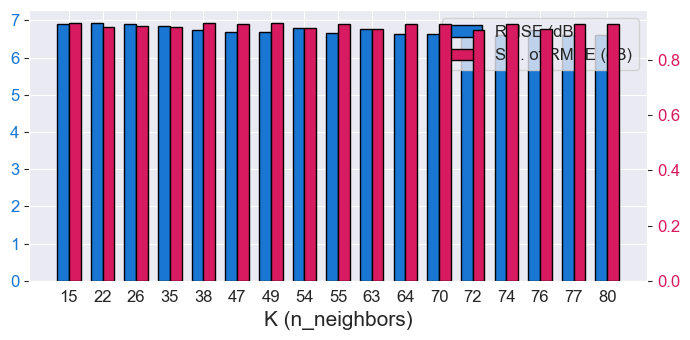

In [22]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12
axis_labelsize = 15
legend_fontsize = 12

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

# Sort by K for a clean x-axis
cv_knn_df = cv_knn_df.sort_values('K').reset_index(drop=True)

x = np.arange(len(cv_knn_df['K']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_knn_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
ax1.set_xlabel('K (n_neighbors)', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_knn_df['K'], fontsize=tick_fontsize, rotation=0)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_knn_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/KNN_bestRMSE_&_STD_perK.png', dpi=2000, bbox_inches='tight')
plt.show()

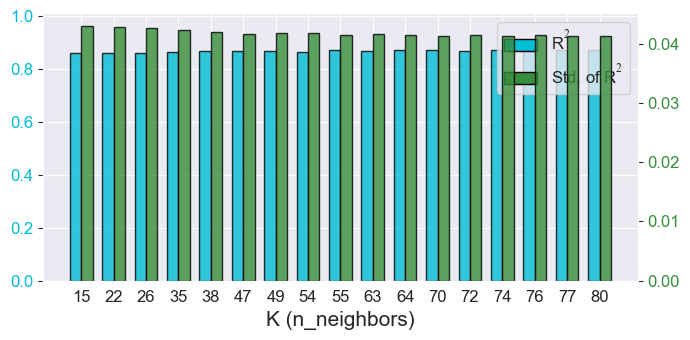

In [23]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12
axis_labelsize = 15
legend_fontsize = 12

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_knn_df['K']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Cyan bars: Best CV R² (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_knn_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('K (n_neighbors)', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_knn_df['K'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# Green bars: STD of CV R² (right y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_knn_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# Combined Legend
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
# plt.savefig('../../Comprehensive ML - Files & Plots etc/KNN_bestR2_STD_perK.png', dpi=2000, bbox_inches='tight')
plt.show()

In [24]:
# Use built-in best_estimator_ (already refitted on full train data) and best_params_
best_knn_model = bayes_cv_knn.best_estimator_
best_knn_params = bayes_cv_knn.best_params_
print("Best KNN Parameters Found:", best_knn_params)

print("\nUsing best KNN model from BayesSearchCV (already trained on all data)...")

y_train_pred = best_knn_model.predict(X_train)
y_test_pred  = best_knn_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)
train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

# Ensure the directory exists and save the trained KNN model
models_dir = '../Models'
os.makedirs(models_dir, exist_ok=True)

with open(os.path.join(models_dir, 'knn_final_model.pkl'), 'wb') as f:
    pickle.dump(best_knn_model, f)

print("Trained KNN model saved to ../Models/knn_final_model.pkl")

Best KNN Parameters Found: OrderedDict({'knn__algorithm': 'auto', 'knn__leaf_size': 80, 'knn__n_neighbors': 80, 'knn__p': 1, 'knn__weights': 'uniform', 'scaler': RobustScaler(quantile_range=(10.0, 90.0))})

Using best KNN model from BayesSearchCV (already trained on all data)...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),10.976300
1,Test Loss (MSE),28.197612
2,Test RMSE,5.310142
3,R² Score (Train),0.968996
4,R² Score (Test),0.920460
5,Test MAPE (%),4.436675
6,Test Median AE,2.950000


Trained KNN model saved to ../Models/knn_final_model.pkl


In [ ]:
figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='neg_root_mean_squared_error'
)

train_rmse = -train_scores.mean(1)
test_rmse  = -test_scores.mean(1)

plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse,  'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('KNN Learning Curve')
plt.legend()
# plt.savefig(f'{path}KNN_learning_curve.png', dpi=300)
plt.show()

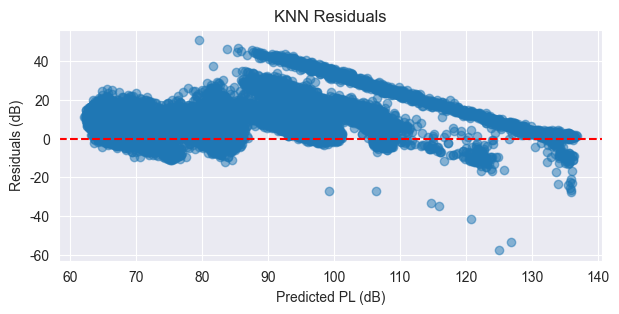

In [ ]:
y_test_pred = best_knn_model.predict(X_test)
residuals = y_test - y_test_pred

plt.figure(figsize=(7, 3))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('KNN Residuals')
# plt.savefig(f'{path}KNN_residuals.png', dpi=300)
plt.show()

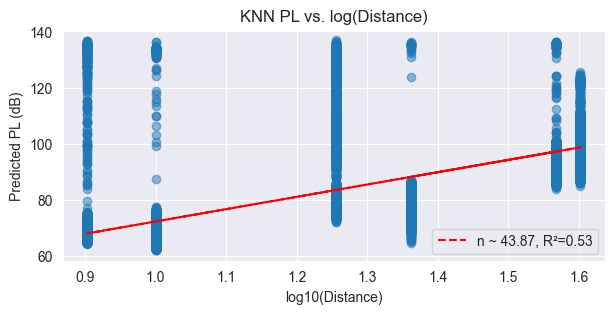

In [ ]:
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)  # guard against log(0)

slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)

plt.figure(figsize=(7, 3))
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--', 
         label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('KNN PL vs. log(Distance)')
plt.legend()
# plt.savefig(f'{path}KNN_physics_consistency.png', dpi=300)
plt.show()

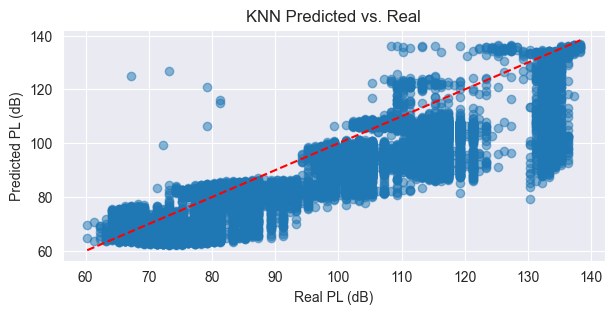

In [ ]:
plt.figure(figsize=(7, 3))
plt.scatter(y_test, y_test_pred, alpha=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('KNN Predicted vs. Real')
# plt.savefig(f'{path}KNN_pred_vs_real.png', dpi=300)
plt.show()

In [ ]:
# Learning curve for kNN using *out-of-fold* "train" error (OOF)
# To avoid the near-zero in-sample training RMSE inherent to kNN with distance weights.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import PredefinedSplit, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error

# Use the same PredefinedSplit you already loaded
ps = PredefinedSplit(fold_assignments)

# Fractions of the training set to evaluate (like learning_curve)
fractions = np.linspace(0.1, 1.0, 5)

rng = np.random.RandomState(42)  # reproducibility
n = X_train.shape[0]

oof_rmse = []
cv_rmse  = []
sizes    = []

# To preserve each fold in the subset, subsample *within each fold* deterministically
unique_folds = np.unique(fold_assignments)

for frac in fractions:
    idx_list = []
    for f in unique_folds:
        f_idx = np.where(fold_assignments == f)[0]
        m = max(1, int(len(f_idx) * frac))
        # deterministic choice: first m (could also shuffle with rng to randomize)
        idx_list.append(f_idx[:m])
    sub_idx = np.concatenate(idx_list)
    sub_idx.sort()

    X_sub = X_train[sub_idx]
    y_sub = y_train[sub_idx]
    ps_sub = PredefinedSplit(fold_assignments[sub_idx])

    # OOF predictions (train-like but honest: never predicts on the fold it was fit on)
    y_oof = cross_val_predict(bayes_cv_knn.best_estimator_, X_sub, y_sub, cv=ps_sub, n_jobs=-1)
    oof_rmse.append(mean_squared_error(y_sub, y_oof, squared=False))

    # CV "test" RMSE (mean over folds)
    scores = cross_val_score(bayes_cv_knn.best_estimator_, X_sub, y_sub,
                             cv=ps_sub, n_jobs=-1,
                             scoring='neg_root_mean_squared_error')
    cv_rmse.append(-scores.mean())
    sizes.append(len(sub_idx))

oof_rmse = np.array(oof_rmse)
cv_rmse  = np.array(cv_rmse)
sizes    = np.array(sizes)


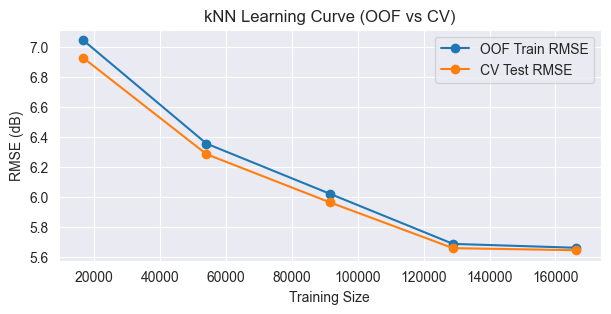

In [ ]:
# Plot: OOF "train" RMSE vs CV "test" RMSE (both honest)
plt.figure(figsize=(7, 3))
plt.plot(sizes, oof_rmse, 'o-', label='OOF Train RMSE')
plt.plot(sizes, cv_rmse,  'o-', label='CV Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('kNN Learning Curve (OOF vs CV)')
plt.legend()
plt.grid(True)
# Save alongside your other figures if you like:
# plt.savefig('../../Comprehensive ML - Files & Plots etc/KNN_learning_curve_OOF.png', dpi=300, bbox_inches='tight')
plt.show()